### Workflow
The <b>first step</b> is to understand the problem and identify potential features and label. Features are those characteristics or attributes which affect the results of the label and that help the model to classify the label correctly. The label is the target variable that we want to predict. In our case, the label is the `Classes` column.

The <b>second step</b> is to <b>preprocess the data.</b> This step is very important because it helps to improve the accuracy of the model. In this step, we will remove the missing values, the outliers, and the duplicated values, if any. We will also analyze and take conclusions about the <b>correlation/relation</b> the various attributes have with the <b>target variable - "Classes".</b>

The <b>third</b> step is to split the data into <u>training</u> and <u>testing</u> sets. The training set is used to train the model and the testing set is used to evaluate the model's performance.

The <b>fourth</b> step is the algorithm implementation, where the data will be split into training and testing sets. For each algorithm, we will capture the results and measure the perfomance (<b>precision, F1-score, recall, accuracy & testing times</b>).

The <b>last</b> step is to compare the results of the different algorithms.


First thing we need to notice is that the original dataset was divided into two regions : Bejaia and SidiBel each containing 122 instances.
Column meanings:
- **Date** : Date of the measurement
- **Temperature** : Temperature in Celsius (22 to 44)
- **RH** : Relative Humidity (21 to 90%)
- **Ws** : Wind speed (6 to 29 km/h)
- **Rain** : Total rain in the day (0 to 16.8 mm)

Then we have the FWI (Fire Weather Index) components. FWI is a classification system that uses the previous columns to determine the risk of fire. 
FWI (Fire Weather Index) column meanings:
- **FFMC** : Fine Fuel Moisture Code (28.6 to 92.5), which measures the moisture of fine combustibles on the forest floor
- **DMC** : Duff Moisture Code (1.1 to 65.9), which measures the moisture in the thickest materials
- **DC** : Drought Code (7.0 to 220.4), which measures the moisture in the soil
- **ISI** : Initial Spread Index (0.0 to 18.5), which measures the inital rate of fire spread
- **BUI** : Build Up Index (1.1 to 68.0), which measure the total amount of fuel available
- **FWI** : Fire Weather Index (0.0 to 31.1), which brings all the previous components together

Finally we have the **Classes** column which is the target variable. It represents wether or not a fire occured in the day.

In [63]:
#Defining Global Variables
DATA_PATH = 'data'
DATA_FILE = 'Algerian_forest_fires_dataset.csv'

#Importing Libraries
import pandas as pd

The dataset contains 3 columns `day, month, year` which can be used to create a `Date` column.
Usually, the `Date` column is dropped when building a model, but in this case, we will use it to exctract the season of the year, which can be a good indicator of the risk of fire.
In this dataset, we have 4 seasons : `Winter, Spring, Summer, Autumn` which are represented by ```0, 1, 2, 3``` respectively.

In [64]:
from datetime import date,datetime
# read csv file
fire_data = pd.read_csv(f'{DATA_PATH}/{DATA_FILE}')
# create Date column
fire_data['Date'] = pd.to_datetime(fire_data[['day','month','year']].apply(lambda x: '/'.join(x.astype(str)),axis = 1), format='%d/%m/%Y')
# remove day, month and year columns
fire_data.drop(['day','month','year'], axis=1, inplace=True)

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
            ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
            ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
            ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
            ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

seasons_index = ['winter', 'spring', 'summer', 'autumn']

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

fire_data['season'] = fire_data['Date'].apply(get_season)
fire_data['season'] = fire_data['season'].apply(lambda x: seasons_index.index(x))
fire_data.drop(['Date'], axis=1, inplace=True)
print(fire_data.head())




   Temperature   RH   Ws  Rain   FFMC  DMC    DC  ISI  BUI  FWI    Classes    \
0           29   57   18    0.0  65.7  3.4   7.6  1.3  3.4  0.5  not fire      
1           29   61   13    1.3  64.4  4.1   7.6  1.0  3.9  0.4  not fire      
2           26   82   22   13.1  47.1  2.5   7.1  0.3  2.7  0.1  not fire      
3           25   89   13    2.5  28.6  1.3   6.9  0.0  1.7    0  not fire      
4           27   77   16    0.0  64.8  3.0  14.2  1.2  3.9  0.5  not fire      

   season  
0       1  
1       1  
2       1  
3       1  
4       1  


We will also delete any whitespaces that the columns might contain and convert to lowercase.

In [65]:
# remove whitespaces from column names
fire_data.columns = fire_data.columns.str.replace(' ', '')
fire_data.columns = fire_data.columns.str.lower()
print(fire_data.columns)

Index(['temperature', 'rh', 'ws', 'rain', 'ffmc', 'dmc', 'dc', 'isi', 'bui',
       'fwi', 'classes', 'season'],
      dtype='object')


One of the first things to do is to identify if there are any missing values in the dataset. We can do this by using the `isnull()` function or using the `info()` function. Since we have a dataset of 244 instaces, we can see that there are no missing values. If there is a row with less than 244 values, then we can conclude that there are missing values.
Right there we can see that the <b>Classes</b> row has 243 values, which means that there is a missing value. We can either delete the row or replace the missing value with the mean of the column. 


In [66]:
# check for missing values in the dataset
missing_values = fire_data.isnull() 
# print the rows that contains missing values
print(fire_data[missing_values.any(axis=1)])

print(fire_data.info())


     temperature  rh  ws  rain  ffmc   dmc      dc   isi   bui      fwi  \
165           37  37  18   0.2  88.9  12.9  14.6 9  12.5  10.4  fire      

    classes  season  
165     NaN       2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  244 non-null    int64  
 1   rh           244 non-null    int64  
 2   ws           244 non-null    int64  
 3   rain         244 non-null    float64
 4   ffmc         244 non-null    float64
 5   dmc          244 non-null    float64
 6   dc           244 non-null    object 
 7   isi          244 non-null    float64
 8   bui          244 non-null    float64
 9   fwi          244 non-null    object 
 10  classes      243 non-null    object 
 11  season       244 non-null    int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 23.0+ KB
None


It can be seen that it is a delimiter problem. The missing value is actually in the same row as the column names, but instead of a `','` it has a `' '`. We will simply delete it since it is only one row.

In [67]:
df = fire_data.dropna(axis = 0, how='any')
df.info()

fire_data = df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 243
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  243 non-null    int64  
 1   rh           243 non-null    int64  
 2   ws           243 non-null    int64  
 3   rain         243 non-null    float64
 4   ffmc         243 non-null    float64
 5   dmc          243 non-null    float64
 6   dc           243 non-null    object 
 7   isi          243 non-null    float64
 8   bui          243 non-null    float64
 9   fwi          243 non-null    object 
 10  classes      243 non-null    object 
 11  season       243 non-null    int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 24.7+ KB


Next, it's always a good idea to look at the distribution of the data. We can do this by using the `describe()` function.

In [68]:
fire_data.describe()

,temperature,rh,ws,rain,ffmc,dmc,isi,bui,season
count,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,32.152263,62.041152,15.493827,0.762963,77.842387,14.680658,4.742387,16.690535,1.901235
std,3.628039,14.828160,2.811385,2.003207,14.349641,12.393040,4.154234,14.228421,0.470755
min,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,0.000000,1.100000,1.000000
25%,30.000000,52.500000,14.000000,0.000000,71.850000,5.800000,1.400000,6.000000,2.000000
50%,32.000000,63.000000,15.000000,0.000000,83.300000,11.300000,3.500000,12.400000,2.000000
75%,35.000000,73.500000,17.000000,0.500000,88.300000,20.800000,7.250000,22.650000,2.000000
max,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,19.000000,68.000000,3.000000


Lets plot the distribution of each columng along the diagonal using scatterplots. Then we can plot a scatterplot matrix for the combination of each variable. It makes an efficient tool to look for errors in the data.

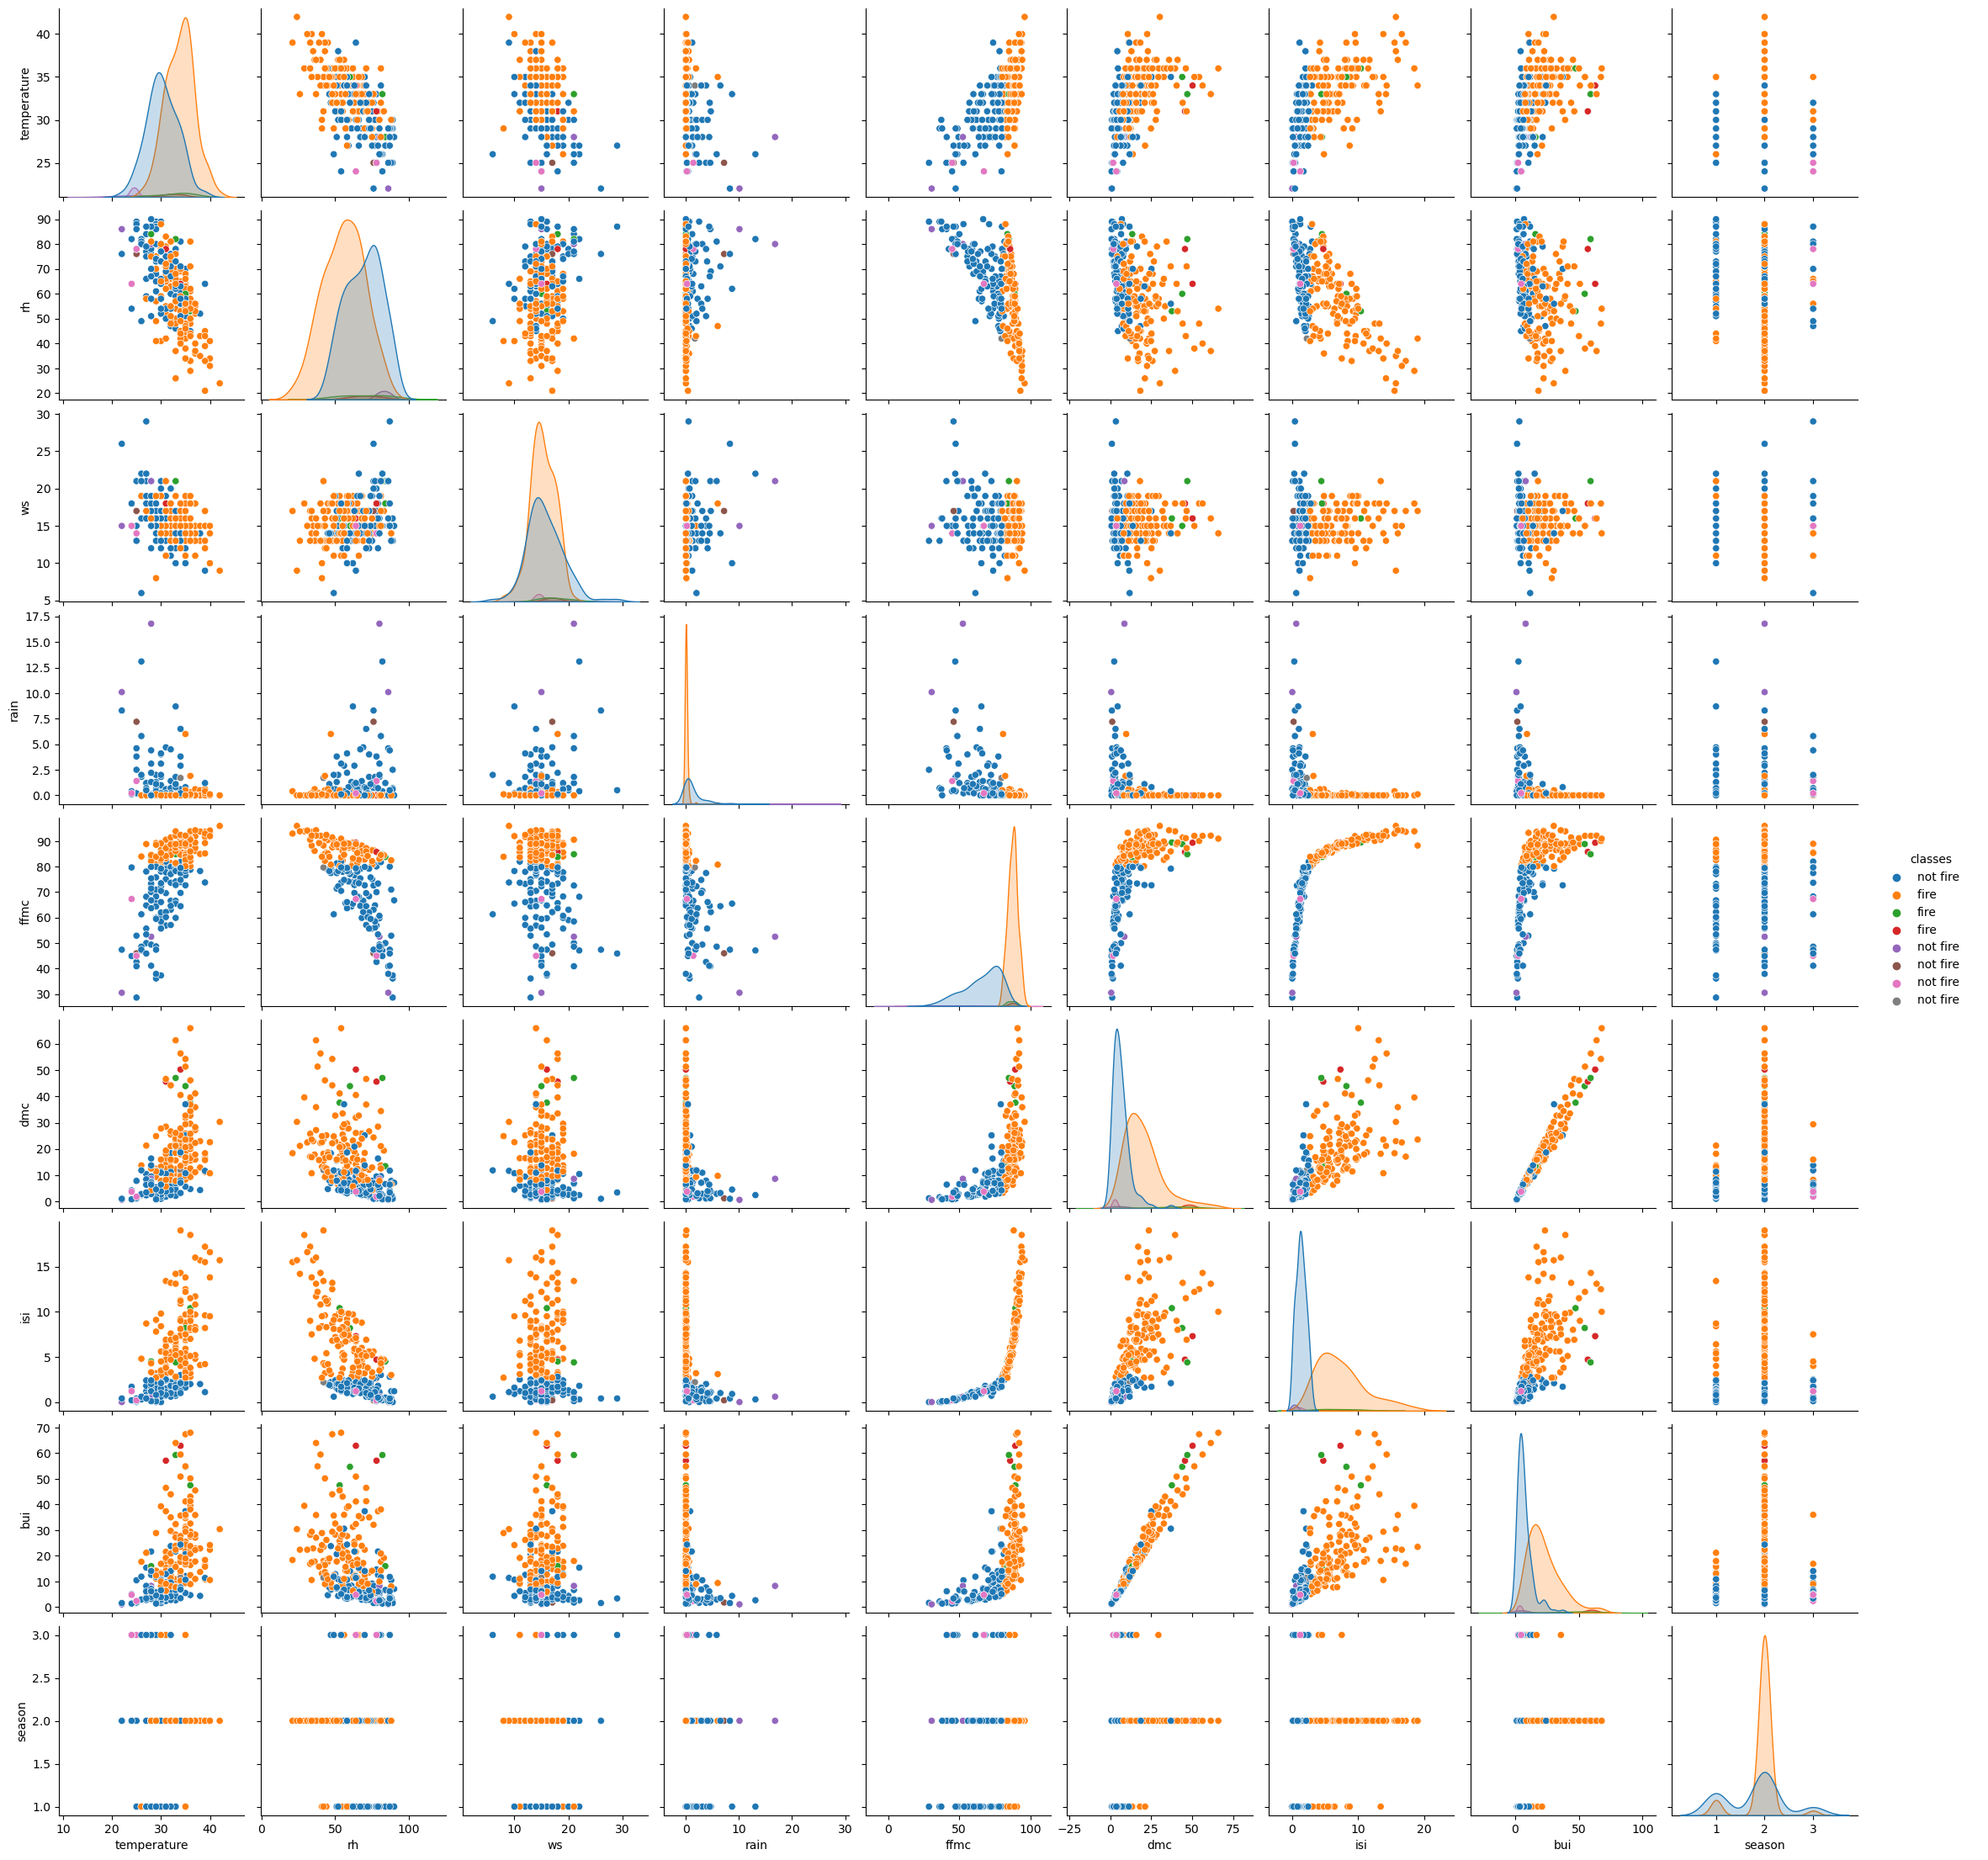

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb 

sb.pairplot(fire_data, hue ='classes')

From this plot, we can see that there are 8 classes when it should only be 2.

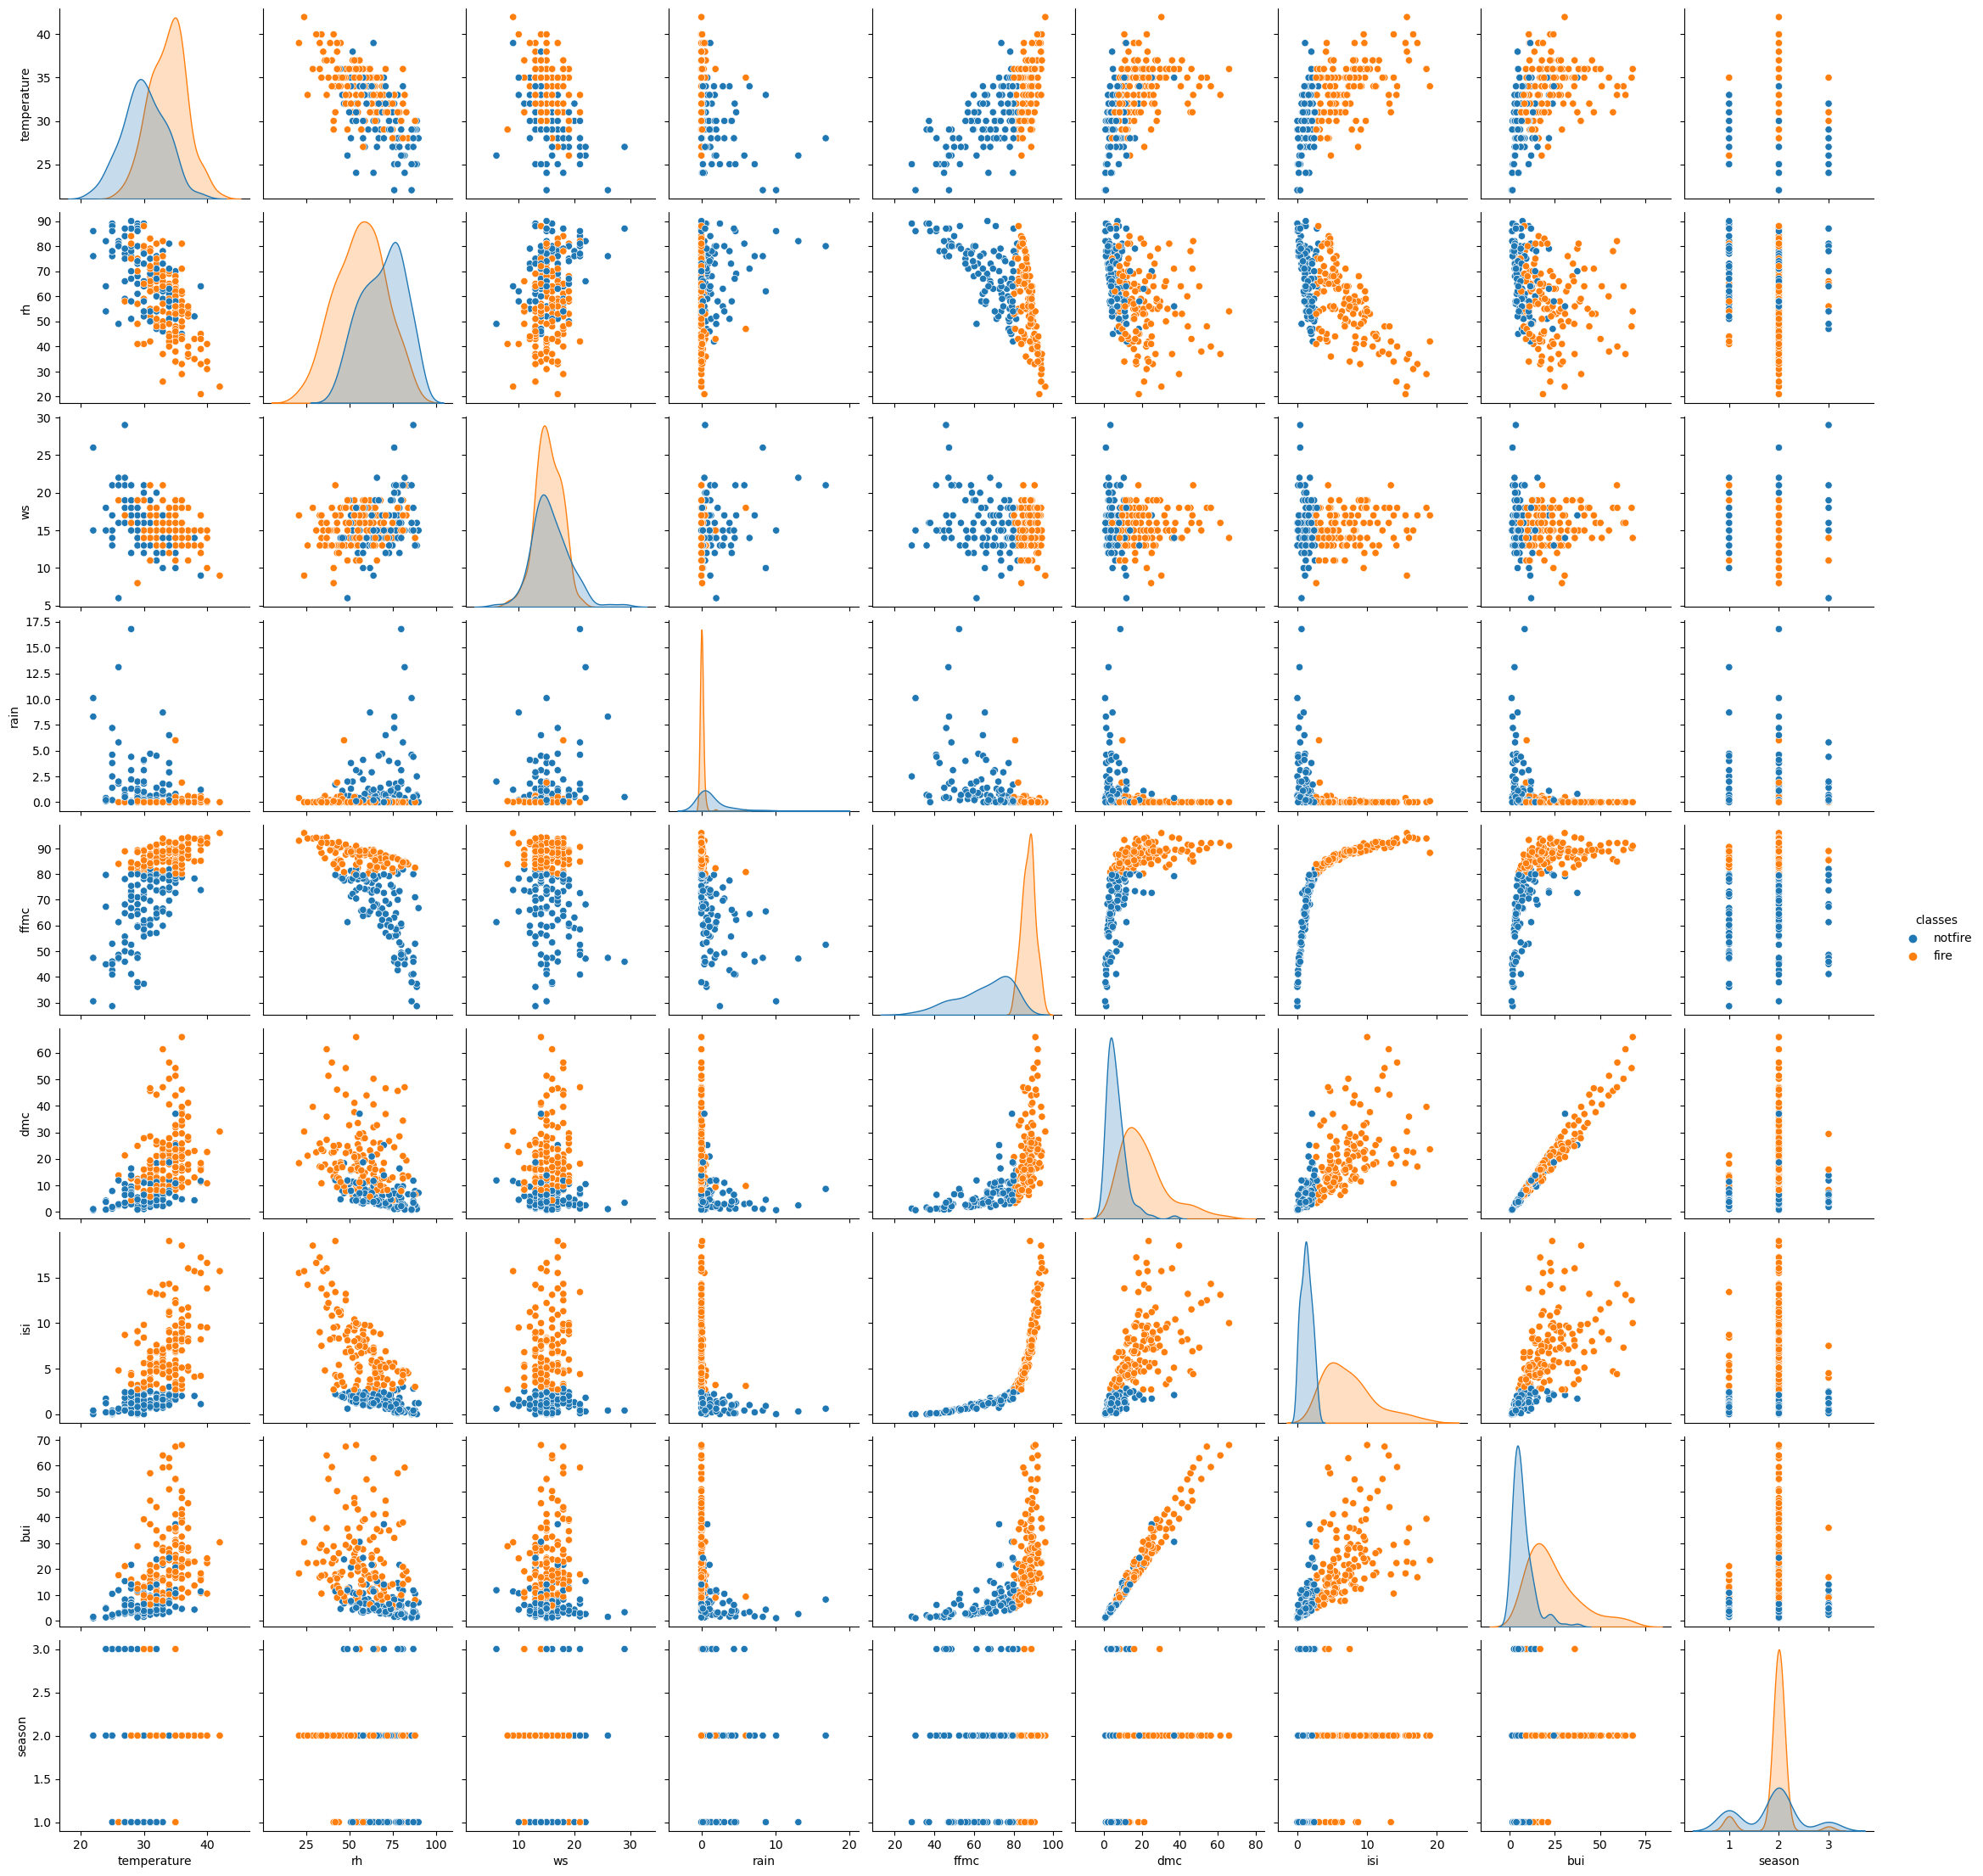

In [70]:
# replace the values of the column Classes remove the whitespaces
fire_data['classes'] = fire_data['classes'].str.replace(' ', '')
# now plot again 
sb.pairplot(fire_data, hue ='classes')

Now that we have 2 classes, we can see that that is a tendency in the FWI components for the fire to occur. There is a clear separation between the two classes, where the left side is the `not fire` class and the right side is the `fire` class.

There are some outliers in the dataset, like the two `Ws` entries around 20-30 and the two `Rain` entries around 10-20, but we will not remove them because they are not errors. They are just extreme values and we think that they are a valuable information for the model.

# Classification

## First Classifier: Naive Bayes
The first classifier we will use is based on Bayes Theorem. It is one of the simplest supervised learning algorithms, but it is fast, accurate and realiable. 
Basicaly, it assumes that the effect of a particular feature in a class is independent of other features. For example, a fruit may be considered to be an apple if it is red, round, and about 3 inches in diameter. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.

### Steps
1. Calculate the prior probability for given class labels
2. Calculate conditional probability for each feature for each class
3. Multiply same class conditional probability
4. Multiply prior probability with the output of previous step
5. Perform this for all the classes, and the class with the highest probability is the outcome of prediction

#### Classifier building in Scikit-learn
Before we start the training process, we need to split the dataset into training and testing for model evaluation.

In [71]:
from sklearn.model_selection import train_test_split
import numpy as np

# since we have integers represented as strings, we need to convert them to float in order to use the algortihm
matrix = np.array(fire_data.drop('classes', axis=1).values)
matrix = matrix.astype(float)

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(matrix, fire_data['classes'].values, test_size=0.33, random_state=125)



#### Model building and training
Let's build a generic Gaussian Naive Bayes and train it on a training dataset.
To visualize the performance of the model, we will use a confusion matrix. It is a table that represents the predicted labels versus the actual labels, showing the number of true positives, true negatives, false positives, and false negatives. It is a good way to evaluate accuracy and identify any misclassifications.

Time spent on training: 0.00100 seconds


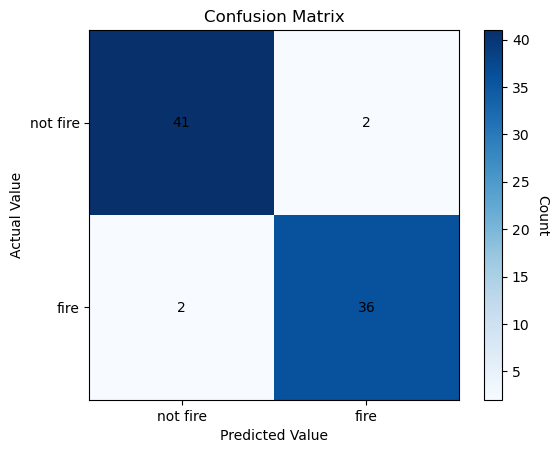

In [72]:
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time

# Build a Gaussian Naive Bayes classifier
model = GaussianNB()

start_time = time.time()

# Train the model using the training sets
model.fit(X_train, y_train)

training_time = time.time() - start_time
print("Time spent on training: {:.5f} seconds".format(training_time))

# Predict the response for test dataset
predicted = model.predict(X_test)

predicted_np = np.where(predicted == 'notfire', 0, 1) # if predicted == 'not fire' then 0 else 1

actual_values = np.where(y_test == 'notfire', 0, 1) # if y_test == 'not fire' then 0 else 1

cm = confusion_matrix(actual_values, predicted_np)


fig, ax = plt.subplots()

im = ax.imshow(cm, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['not fire', 'fire'])
ax.set_yticklabels(['not fire', 'fire'])
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual Value')
ax.set_title('Confusion Matrix')

# Add text annotations to the plot
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
        
# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count', rotation=-90, va='bottom')

# Display the plot
plt.show()


We can see the accuracy values too:

In [73]:
from sklearn.metrics import (accuracy_score, f1_score)

accuray = accuracy_score(predicted, y_test)
f1 = f1_score(predicted, y_test, average='weighted')

print(f'Accuracy: {accuray}')
print(f'F1 Score: {f1}')

Accuracy: 0.9506172839506173
F1 Score: 0.9506172839506173
